# Project 1 - Iowa Liquor 

You are a data scientist in residence at the Iowa State tax board. The Iowa State legislature is considering changes in the liquor tax rates and wants a report of current liquor sales by county and projections for the rest of the year. 

Your task is as follows:

* Calculate the yearly liquor sales for each store using the provided data. You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable.
* Use the data from 2015 to make a linear model using as many variables as you find useful to predict the yearly sales of all stores. You must use the sales from Jan to March as one of your variables.
* Use your model for 2015 to estimate total sales in 2016, extrapolating from the sales so far for Jan-March of 2016.
* Report your findings, including any projected increase or decrease in total sales (over the entire state) for the tax committee of the Iowa legislature.
* Use cross-validation to check how your model predicts to held out data compared to the model metrics on the full dataset.
* Fit your model(s) using one or both of the regularization tactics covered. Explain whether the regularized or the non-regularized model performed better and what the selected regression(s) are doing.



# Part 2

### Feature Engineering, Model Building, and Tuning

In Part 2 of this two-part project, you will use the insights gained from your Exploratory Data Analysis (EDA) to build a linear regression model predicting end-of-year total sales using Q1 data. You will use 2015 data to train and tune your model, then make final predictions using Q1 2016 data to make your best estimates for end of year 2016!

### Requirements:


**Mine the data**
- Create necessary derived columns from the data
- Format, clean, slice, and combine the data in Python

**Build a data model**
- Complete linear regressions using scikit-learn or statsmodels and interpret your findings
- Calculate and plot predicted probabilities and/or present tables of results
- Describe the bias-variance tradeoff of your model and errors metrics
- Evaluate model fit by using loss functions, including mean absolute error, mean squared error, and root mean squared error, or r-squared

**Present the results**
- Create a Jupyter Notebook hosted on GitHub that provides a dataset overview with visualizations, statistical analysis, data cleaning methodologies, and models
- Create a write-up on the interpretation of findings including an executive summary with conclusions and next steps

***Bonus!:***
- Handle outliers, use regularization (Ridge & Lasso regressions)
- Brainstorm ways to improve your analysis; for example:
 - Add additional breakdowns and models, e.g. by month.
 - Recommend additional data that might improve your models
 - Can you think of other uses for the dataset? E.g healthcare / disease estimates

In [1]:
import os

os.path.isfile('../Assets/Iowa_Liquor_sample.csv') 

True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Import and Clean data:

This time, we've cleaned the data set and column names for you; however we have not touched missing values.

In [3]:
# Import, convert 'Date' col to datetime
liquor=pd.read_csv('../Assets/Iowa_Liquor_sample.csv',parse_dates=['Date'],infer_datetime_format=True)

In [4]:
# format column names
import re

liquor.columns = [re.sub("[^a-zA-Z]+", "", x) for x in liquor.columns]

In [5]:
# remove '$' in values and convert to numeric
adjust_cols = ['StateBottleCost','StateBottleRetail','SaleDollars']

for col in adjust_cols:
    liquor[col] = pd.to_numeric(liquor[col].str.replace('$',''),errors='coerce')

### Null Values

Handle null values as you see fit

I'm just going to drop all the null values for a couple of reasons. First, the columns with the most null values are County and CountyNumber which I am not going to use in my features anyways. Second, I may not be able to trust any of the data in the rows with null values. I'm not too worried about throwing off my model much by doing this, because even though it eliminates some stores entirely, it is only a little over 1,000 rows in a 270,000 row file.

In [6]:
# drop nulls
liquor = liquor.dropna()
liquor.shape

(269258, 18)

In [7]:
liquor.isnull().sum()

Date                 0
StoreNumber          0
City                 0
ZipCode              0
CountyNumber         0
County               0
Category             0
CategoryName         0
VendorNumber         0
ItemNumber           0
ItemDescription      0
BottleVolumeml       0
StateBottleCost      0
StateBottleRetail    0
BottlesSold          0
SaleDollars          0
VolumeSoldLiters     0
VolumeSoldGallons    0
dtype: int64

## Split Data to Create a features and targets

The goal of this project is to predict **total year-end 2015 sales for each store** using **first-quarter 2015 data**

Our data is currently formatted as total purchases for each product per day per store for every day in the year. We will need to group our data by store when we perform our aggregations.

In order to accomplish our goal, we need two sets of data:
* Total full-year  sales for each store in 2015 (our target / y)
* Data from Q1 2015 (will become our features / X)

Create two dataframes, 'liquor2015_fy' and 'liquor2015_q1'

'liquor2015_fy' should contain only store numbers and the full year sales for that store

'liquor2015_q1' should contain all your features, but only for Q1


In [15]:
liquor[liquor.Date.dt.year == 2015].shape

(218348, 18)

In [87]:
# Filter to only 2015:
# hint: liquor.Date.dt._______

liquor2015 = liquor[liquor.Date.dt.year == 2015]

In [95]:
# Calculate the sum of sales for each store in 2015 by grouping the full year data
# hint: what columns do you need? what is your aggregating function? 
Total2015 = liquor2015.groupby('StoreNumber').SaleDollars.sum()
liquor2015_fy = Total2015.to_frame('Target')

In [ ]:
# Filter to just Q1 data: 
# hint: df[df.Date.dt.___ == __]

In [28]:
liquor2015_q1 = liquor2015[liquor2015.Date.dt.quarter == 1]

# Feature Engineering

Using the insight your gained into your dataset while perfomorming *exploratory data analysis* in Part 1 of the project, aggregate the liquor2015_q1 data frame to create cross-sectional features from our longitudinal data.


[Aggregation functions in pandas](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

In addition to aggregation, you may chose to create columns to more advanced measures of the data, such as sales for a particular product or category, measures of profitbility, daily or weekly sales statistics, etc.

Combine your aggregations and other engineered features into a dataframe called 'liquor2015_q1_features'

*At a minimum, you will need to aggreate your features by Store in order to procede*



In [72]:
q1_store_sales = liquor2015_q1.groupby('StoreNumber').SaleDollars.sum()

StoreNumber
2106    39287.29
2113     2833.25
2130    24272.57
2152     2003.46
2178     5856.41
2190    29452.92
2191    29085.57
2200     4900.43
2205     6407.74
2228     5193.97
2233     5374.55
2238      858.61
2248    12663.68
2285    10019.12
2290    12085.15
2327     2253.60
2353    17382.60
2367     2023.44
2413    22459.16
2445     1215.08
2448     5655.92
2459     1609.57
2460     6746.61
2465     5615.99
2475     5672.76
2478     4459.85
2487     7256.60
2498      279.22
2500    40234.90
2501    31412.95
          ...   
5086      810.60
5088      479.16
5089      884.03
5090     2193.89
5091      523.82
5092     1815.54
5093     2430.57
5094      511.86
5096     2040.42
5097     3160.02
5098     1360.74
5099     1250.49
5100     2180.76
5101     1701.47
5102    27695.76
5103       42.76
5104     1555.83
5105     2708.56
5106     2691.84
5108      999.95
5112      803.56
5113     2427.84
5114      406.02
5115      601.02
5116     1406.57
5119      112.50
5128      477.00
90

In [48]:
q1_bottle_volume = liquor2015_q1.groupby('StoreNumber').VolumeSoldLiters.sum()

In [49]:
q1_bottles_sold = liquor2015_q1.groupby('StoreNumber').BottlesSold.sum()

In [54]:
liquor2015_q1.head()

,Date,StoreNumber,City,ZipCode,CountyNumber,County,Category,CategoryName,VendorNumber,ItemNumber,ItemDescription,BottleVolumeml,StateBottleCost,StateBottleRetail,BottlesSold,SaleDollars,VolumeSoldLiters,VolumeSoldGallons
12,2015-01-22,3858,DAVENPORT,52806,82.0,Scott,1012100.0,CANADIAN WHISKIES,65,15248,Windsor Canadian Pet,1750,8.92,13.38,1,13.38,1.75,0.46
19,2015-03-04,2614,DAVENPORT,52807,82.0,Scott,1012100.0,CANADIAN WHISKIES,434,13638,Lord Calvert Canadian Whisky,1750,9.97,14.96,6,89.76,10.50,2.77
20,2015-01-16,2590,CEDAR RAPIDS,52402,57.0,Linn,1031200.0,VODKA FLAVORED,971,41474,44 North Huckleberry,750,14.25,21.38,2,42.76,1.50,0.40
21,2015-01-13,3942,TOLEDO,52342,86.0,Tama,1012100.0,CANADIAN WHISKIES,115,11786,Black Velvet Traveler,750,5.23,7.85,12,94.20,9.00,2.38
22,2015-03-24,3981,SIOUX CENTER,51250,84.0,Sioux,1011100.0,BLENDED WHISKIES,260,25606,Seagrams 7 Crown Bl Whiskey,750,7.00,10.50,12,126.00,9.00,2.38


In [57]:
# liquor2015_q1['Week'] = liquor2015_q1.Date.dt.week

In [50]:
avg_bottle_price = liquor2015_q1.StateBottleRetail.mean()

In [83]:
# Dataframe of your Q1 features
liquor2015_q1_features = q1_store_sales.to_frame(name='TotalSales')

In [85]:
liquor2015_q1_features['BottlesSold'] = q1_bottles_sold
liquor2015_q1_features['VolumeSold'] = q1_bottle_volume

In [82]:
liquor2015_q1_features.head()

,TotalSales,BottlesSold,VolumeSold
StoreNumber,,,
2106,39287.29,2705,2526.10
2113,2833.25,196,177.11
2130,24272.57,1533,1447.25
2152,2003.46,154,151.74
2178,5856.41,490,409.81


## Combine Q1 Features with Full Year Target

Now that you've created a set of features using the Q1 data, we much combine it wil the full-year data so that our Xs (features) are matched up to their coresponding y's (targets).

Pandas' 'merge' function allows us to combine two dataframes, using SQL-like joins.

[Pandas Merge/Join Documentation](https://pandas.pydata.org/pandas-docs/stable/merging.html#database-style-dataframe-joining-merging)

We will create a new dataframe, called 'liquor2015_combined' by merging our 'liquor2015_fy' and 'liquor2015_q1_features' dataframes on Store Number - giving us a dataframe which in each row has the Q1 features you've developed for each store, and the year-end total sales for that store.

#### In pandas, merge can take two forms:

pd.merge(left_dataframe,right_dataframe, \*\*args)

*or*

left_dataframe.merge(right_dataframe,\*\*args)

Both of these return the merged dataframe. For arguments, you will need to chose which column(s) from your right and left dataframe you're merging on.

Args:
* left: your left-dataframe
* right: your right-dataframe
* on= : if your dataframes have a common column name that you're merging on, use this arg
* left_on= / right_on= : if your dataframes do not have a common column name, you can specify the names
* left_index= / right_index= : these are boolean (True/False) flags for whether to use the dataframe's index as the merging column.



In [99]:
liquor2015_combined = pd.merge(liquor2015_q1_features, liquor2015_fy, left_index=True, right_index=True)

In [187]:
liquor2015_combined.head()

,TotalSales,BottlesSold,VolumeSold,Target
StoreNumber,,,,
2106,39287.29,2705,2526.10,146038.70
2113,2833.25,196,177.11,9310.22
2130,24272.57,1533,1447.25,111583.91
2152,2003.46,154,151.74,7721.08
2178,5856.41,490,409.81,24324.18


## Cross Validation

As we build our model, we will use cross-validation techniques to help navigate the bias/variance tradeoff, with a goal of producing the best model which will generalize to new data. 

![crossval](../Assets/validation.png)

### Step 1: Hold Out / Testing Data

In order to evaluate our final model performance, we will seperate out a small amount of data which will will not touch while train and test our model (labeled in red as "Testing Data" in the image above). 

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
training_data,holdout = train_test_split(liquor2015_combined,shuffle=True,test_size=0.10,random_state=123)

### Step 2: Kfolds

With our holdout set removed, we can set up **Kfolds** cross validation

In [105]:
from sklearn.model_selection import KFold

In [106]:
# Number of folds you wish to train
folds = 7

# Number of rows in your dataframe
n = training_data.shape[0]

kf = KFold(n_splits=folds,random_state=123)

# Model Building - Linear Regression

With feature prepared and a cross-validation framework in place, train and tune a linear regressor to predict year-end sales using your q1 data

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np

In [160]:
#select your feature column names

feature_cols = ['TotalSales','VolumeSold','BottlesSold']

In [161]:
# define your X (features) and y (target)
# hint - make sure your y is not in your X!

X = training_data[feature_cols]
y = training_data['Target']


Instantiate your model

In [162]:
lr = LinearRegression()

Use the kfolds iterator to **train** and **evaluate** your model, using Mean Squared Error (MSE) as your evluation metric

In [163]:
# Create a blank list to store fold scores
scores = []
# Fill-in the kfolds-loop:

for train,test in kf.split(X):
    # Set up your training and testing sets
    x_train = X.iloc[train]
    x_test = X.iloc[test]
    y_train = y.iloc[train]
    y_true = y.iloc[test]
    
    # Fit your model on your training x and training y
    lr.fit(x_train,y_train)
    
    # Make Predictions
    y_preds = lr.predict(x_test)
    
    # Score your predictions vs. your true values using mean_squared_error
    fold_score = mean_squared_error(y_true, y_preds)
    
    # Append your score 
    scores.append(fold_score)


In [164]:
# View your fold scores, and calculate the mean score across your folds
# np.mean()

In [165]:
scores

[65070114.520666689,
 66087242.77469635,
 65500766.708966009,
 108197955.56544016,
 190894353.25969371,
 101804806.282245,
 127558723.93848363]

In [166]:
np.mean(scores)

103587709.00717022

### Coefficients and Intercept

View the coefficients of your model - what do the coefficients tell you about the relationships between your features and your target?

In [119]:
list(zip(feature_cols,lr.coef_))

[('TotalSales', 5.4060729000315142),
 ('BottlesSold', 5.3083234997544828),
 ('VolumeSold', -19.434391655920706)]

In [121]:
# These coefficients give me the impact on total 2015 sales that results from changes in either of the three features columns

In [120]:
lr.intercept_

628.82262236201859

In [122]:
# The intercept tells me that assuming all the feature values were zero, the SaleDollars for the store would be $628

### Tuning Your Model

So far, you've trained a basic linear model and evaluated it using Mean Squared Error. Use the same process as above to evaluate your model using: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and calculate the R2 score of your predictions.

Try some of the parameters available for your linear model, and different sets of features to find a model that you feel will **perform best on new, out of sample data**

In [175]:
feature_cols_new = ['TotalSales','BottlesSold']

In [176]:
X = training_data[feature_cols_new]

In [177]:
# Use K-Folds cross validation to train your model
# Evaluate your model using MAE, MSE, RMSE and R2 

In [178]:
# Create a blank list to store fold scores
scores = []
# Fill-in the kfolds-loop:

for train,test in kf.split(X):
    # Set up your training and testing sets
    x_train = X.iloc[train]
    x_test = X.iloc[test]
    y_train = y.iloc[train]
    y_true = y.iloc[test]
    
    # Fit your model on your training x and training y
    lr.fit(x_train,y_train)
    
    # Make Predictions
    y_preds = lr.predict(x_test)
    
    # Score your predictions vs. your true values using mean_squared_error
    fold_score = mean_absolute_error(y_true, y_preds)
    
    # Append your score 
    scores.append(fold_score)


In [179]:
print('MAE:')
scores

MAE:


[4038.1718128365487,
 4135.0178932885574,
 3966.6250666676156,
 4817.4969538439218,
 5582.7098166390097,
 4606.6384383780751,
 5540.2453435445786]

In [180]:
# Create a blank list to store fold scores
scores = []
# Fill-in the kfolds-loop:

for train,test in kf.split(X):
    # Set up your training and testing sets
    x_train = X.iloc[train]
    x_test = X.iloc[test]
    y_train = y.iloc[train]
    y_true = y.iloc[test]
    
    # Fit your model on your training x and training y
    lr.fit(x_train,y_train)
    
    # Make Predictions
    y_preds = lr.predict(x_test)
    
    # Score your predictions vs. your true values using mean_squared_error
    fold_score = np.sqrt(mean_squared_error(y_true, y_preds))
    
    # Append your score 
    scores.append(fold_score)


In [181]:
print('RMSE')
scores

RMSE


[8214.4967638525086,
 8710.0636894687941,
 8688.7973039158642,
 10483.595685453547,
 14165.122347154042,
 10055.759760576897,
 10949.526077278142]

In [182]:
# Create a blank list to store fold scores
scores = []
# Fill-in the kfolds-loop:

for train,test in kf.split(X):
    # Set up your training and testing sets
    x_train = X.iloc[train]
    x_test = X.iloc[test]
    y_train = y.iloc[train]
    y_true = y.iloc[test]
    
    # Fit your model on your training x and training y
    lr.fit(x_train,y_train)
    
    # Make Predictions
    y_preds = lr.predict(x_test)
    
    # Score your predictions vs. your true values using mean_squared_error
    fold_score = r2_score(y_true, y_preds)
    
    # Append your score 
    scores.append(fold_score)


In [183]:
print('R2 Score')
scores

R2 Score


[0.96180318921813934,
 0.87269173261817468,
 0.95691877642995193,
 0.94599585172900591,
 0.98267583670663572,
 0.86063451539468905,
 0.91481082906327749]

In [184]:
# Compare your MAE, MSE, RMSE and R2 values for your folds; describe anything that stands out.
# How do your metrics respond to different feature sets?

There seems to be a lot of variability between the folds, especially looking at MSE. I think that this is largely due to the fact that some of the stores had very little sales and there were a couple of large outliers that would have a skewing effect.

Changing the features didn't have much of an impact on MSE, but I also need some more features to really tune the model most effectively.'

In [185]:
# Evaluate your coefficients and your intercept

The coefficient for total sales makes intuitive sense because an increased dollar in q1 would roughly extrapolate to 4-5 expected more dollars for the year overall. The large negative value for Volume Sold is less logical, I think mostly because of scale.

## Test against your hold-out set

Before you build your model, you set aside some of your data for testing. Your model has never trained against these data points or been evaluated agaist these points.

Use **ALL** of your training data to train, then test your model against your holdout set.

In [190]:
# Pick your best set of feature columns
features = ['TotalSales', 'BottlesSold']

X_train = training_data[features]
y_train = training_data['Target']

x_holdout = holdout[features]
y_holdout = holdout['Target']

In [191]:
lr = LinearRegression()

In [192]:
# Fit your model using all of your training data
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [193]:
# Create predictions using your holdout set (x_holdout)
holdout_preds = lr.predict(x_holdout)

In [195]:
# score your model using MAE, MSE, RMSE, and R2
# hint: what is y_test and what is your y_true?

MAE_score = mean_absolute_error(y_holdout, holdout_preds)
MSE_score = mean_squared_error(y_holdout, holdout_preds)
RMSE_score = np.sqrt(mean_squared_error(y_holdout, holdout_preds))
R2_score = r2_score(y_holdout, holdout_preds)


In [197]:
# print your scores
print('MAE: ',MAE_score)
print('MSE: ',MSE_score)
print('RMSE: ',RMSE_score)
print('R2: ',R2_score)

MAE:  5245.72321958
MSE:  103151374.951
RMSE:  10156.3465356
R2:  0.947055480915


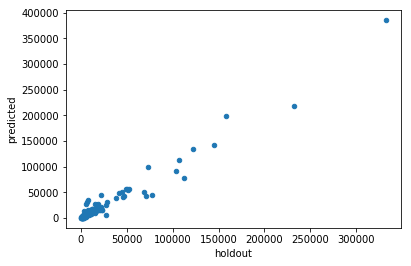

In [202]:
# Create a scatter plot of your predicted values vs. their true values
# Describe anything you observe
plotdata = y_holdout.to_frame('holdout')
plotdata['predicted'] = holdout_preds
plotdata.plot(kind='scatter',x='holdout', y='predicted')

In [203]:
# Calculate your residuals (prediction - actual)
resids = holdout_preds - y_holdout
plotdata['residuals'] = resids

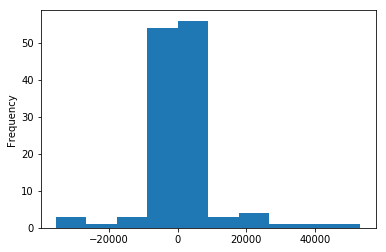

In [204]:
# Create a histogram of your residuals. Describe anything you observe
plotdata.residuals.plot(kind='hist')

# Final Predictions

You've created a model that predicts 2015 year end sales based on Q1 2015 data. 

In the data source, we have included data for Q1 of 2016. Apply your feature engineering process to the 2016 Q1 data, then use your trained 2015 model to predict the 2016 year end values for those stores.

Note: you do not have the 2016 year end values to evaluate against.


### Feature Engineering
Perform the same aggregation and feature creation you used on 2015 data on the 2016 data 

In [ ]:
# liquour[liquor.Date.dt.Year == 2016]

In [207]:
liquor2016 = liquor[liquor.Date.dt.year == 2016]
liquor2016_q1 = liquor2016[liquor2016.Date.dt.quarter == 1]

In [210]:
liquor2016_store_sales = liquor2016_q1.groupby('StoreNumber').SaleDollars.sum()

In [211]:
liquor2016_bottle_volume = liquor2016_q1.groupby('StoreNumber').VolumeSoldLiters.sum()

In [212]:
liquor2016_bottles_sold = liquor2016_q1.groupby('StoreNumber').BottlesSold.sum()

In [216]:
liquor2016_features = liquor2016_store_sales.to_frame(name='TotalSales')

In [217]:
liquor2016_features['BottlesSold'] = liquor2016_bottles_sold

### Make Predictions

Once you have your 2016 features, use your trained 2015 model on the 2016 Q1 data to get your predictions for 2016

Do not retrain a model on the 2016 data*

In [ ]:
# Make Predictions

In [219]:
pred_2016_totals = lr.predict(liquor2016_features)

In [ ]:
# Show your 2016 year-end prediction for each store

In [227]:
pred_2016_df = pd.DataFrame(data = pred_2016_totals, index= liquor2016_features.index)

In [230]:
pred_2016_df.columns = ['pred_2016_totals']

In [232]:
pred_2016_df

,pred_2016_totals
StoreNumber,
2106,137722.224883
2113,9457.462266
2130,125321.643343
2152,4256.417978
2178,25481.762278
2190,143906.928976
2191,212289.180158
2200,18885.425433
2228,14056.894655


# Evaluation:

Do your best to answer the following questions:

* What was the best set of features you found for your model?
* Describe the relationships between your features and your target
* How did your model perform in the training phase? Against the holdout set? 
* Did it perform better or worse against the holdout set?

Finally:
* Write a short description of your analysis, describing the process you went through and your confidence in your model's predictive ability
* Include any data, or visualizations you feel would help support your findings

The best set of features that I was able to find were Bottles Sold and Total Sales by store. With more creative features, I'm pretty sure that my prediction would have been more accurate.

In [233]:
lr.coef_

array([ 4.37964794,  1.85841804])

Given the above coefficients of my model, I would say that the relationship between my features and my target relied heavily on Total Sales for q1. The number of bottles sold in q1 also had a direct effect but only increased total sales by 1.8 for each bottle sold.

My model had a pretty high R2 value but I think that a RMSE of over 10,000 could actually be pretty poor depending on the store because some stores had very low values. I would say it performed decently well in the training phase but I still had a margin of error of around 1.3 million which would be a lot for the tax board to have to tolerate.

My process essentially consisted of creating features from aggregating by store number and using the sums of those features to predict the total sales by store. Given more time to engineer more imaginative features, I think that my model's predictive ability would improve. I also think that bringing in other data sets like census data, population data, liquor drinks per capita, etc. would make my model very robust. However, considering how simple my model is, I'm not that confident in its predictive ability.

# Bonus - Regularization & Grid Search

As a bonus, experiment with the effect of Lasso (L1) and Ridge (L2) regularization on your linear model. Use GridSearch to tune your additional parameters.

See [gridseach 'scoring' options](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for a list of scoring function strings recognized by GridSeach

In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.grid_search import GridSearchCV

In [ ]:
# Instantiate models
lr_ridge = 
lr_lasso = 

In [ ]:
# Use your post-holdout training data, so you can evaluate on the holdout later
X = 
y = 

Expirement with values of Alpha, scoring functions, and L1/L2 regulatization

In [ ]:
params = {'alpha':[0.2,1.0]}

In [ ]:
gs = GridSearchCV(<model>,params,cv=5,scoring='neg_mean_squared_error')

In [ ]:
# Gridsearch incorporates k-folds validation
# You do not have to create training/testing splits
gs.fit(X,y)

In [ ]:
# View all permutation scores
gs.grid_scores_

In [ ]:
# use the best set of parameters
lr_best = gs.best_estimator_

In [ ]:
# try the best estimator on your holdout set

## Evaluation:

Did regularization improve your model? What was the impact of regularization on your features? Did regularization make any features stand out?